(Missing Data Imputation)=
# Missing Data Imputation

:::{post} January, 2023
:tags: missing data, multiple imputation, 
:category: advanced
:author: Nathaniel Forde
:::

## Introduction

In [4]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import scipy.optimize

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Missing Data: Employee Satisfaction Surveys


In [292]:
df_employee = pd.read_csv('../data/employee.csv')
df_employee

,employee,team,turnover,male,empower,lmx,worksat,climate,cohesion
0,1,1,0.0,1,32.0,11.0,3.0,18.0,3.5
1,2,1,1.0,1,NaN,13.0,4.0,18.0,3.5
2,3,1,1.0,1,30.0,9.0,4.0,18.0,3.5
3,4,1,1.0,1,29.0,8.0,3.0,18.0,3.5
4,5,1,1.0,0,26.0,7.0,4.0,18.0,3.5
...,...,...,...,...,...,...,...,...,...
625,626,105,1.0,0,28.0,5.0,4.0,21.0,5.0
626,627,105,1.0,0,17.0,5.0,3.0,21.0,5.0
627,628,105,1.0,1,28.0,10.0,4.0,21.0,5.0
628,629,105,0.0,0,NaN,9.0,4.0,21.0,5.0


Text(0.5, 1.0, 'Employee Satisfaction Survey Results')

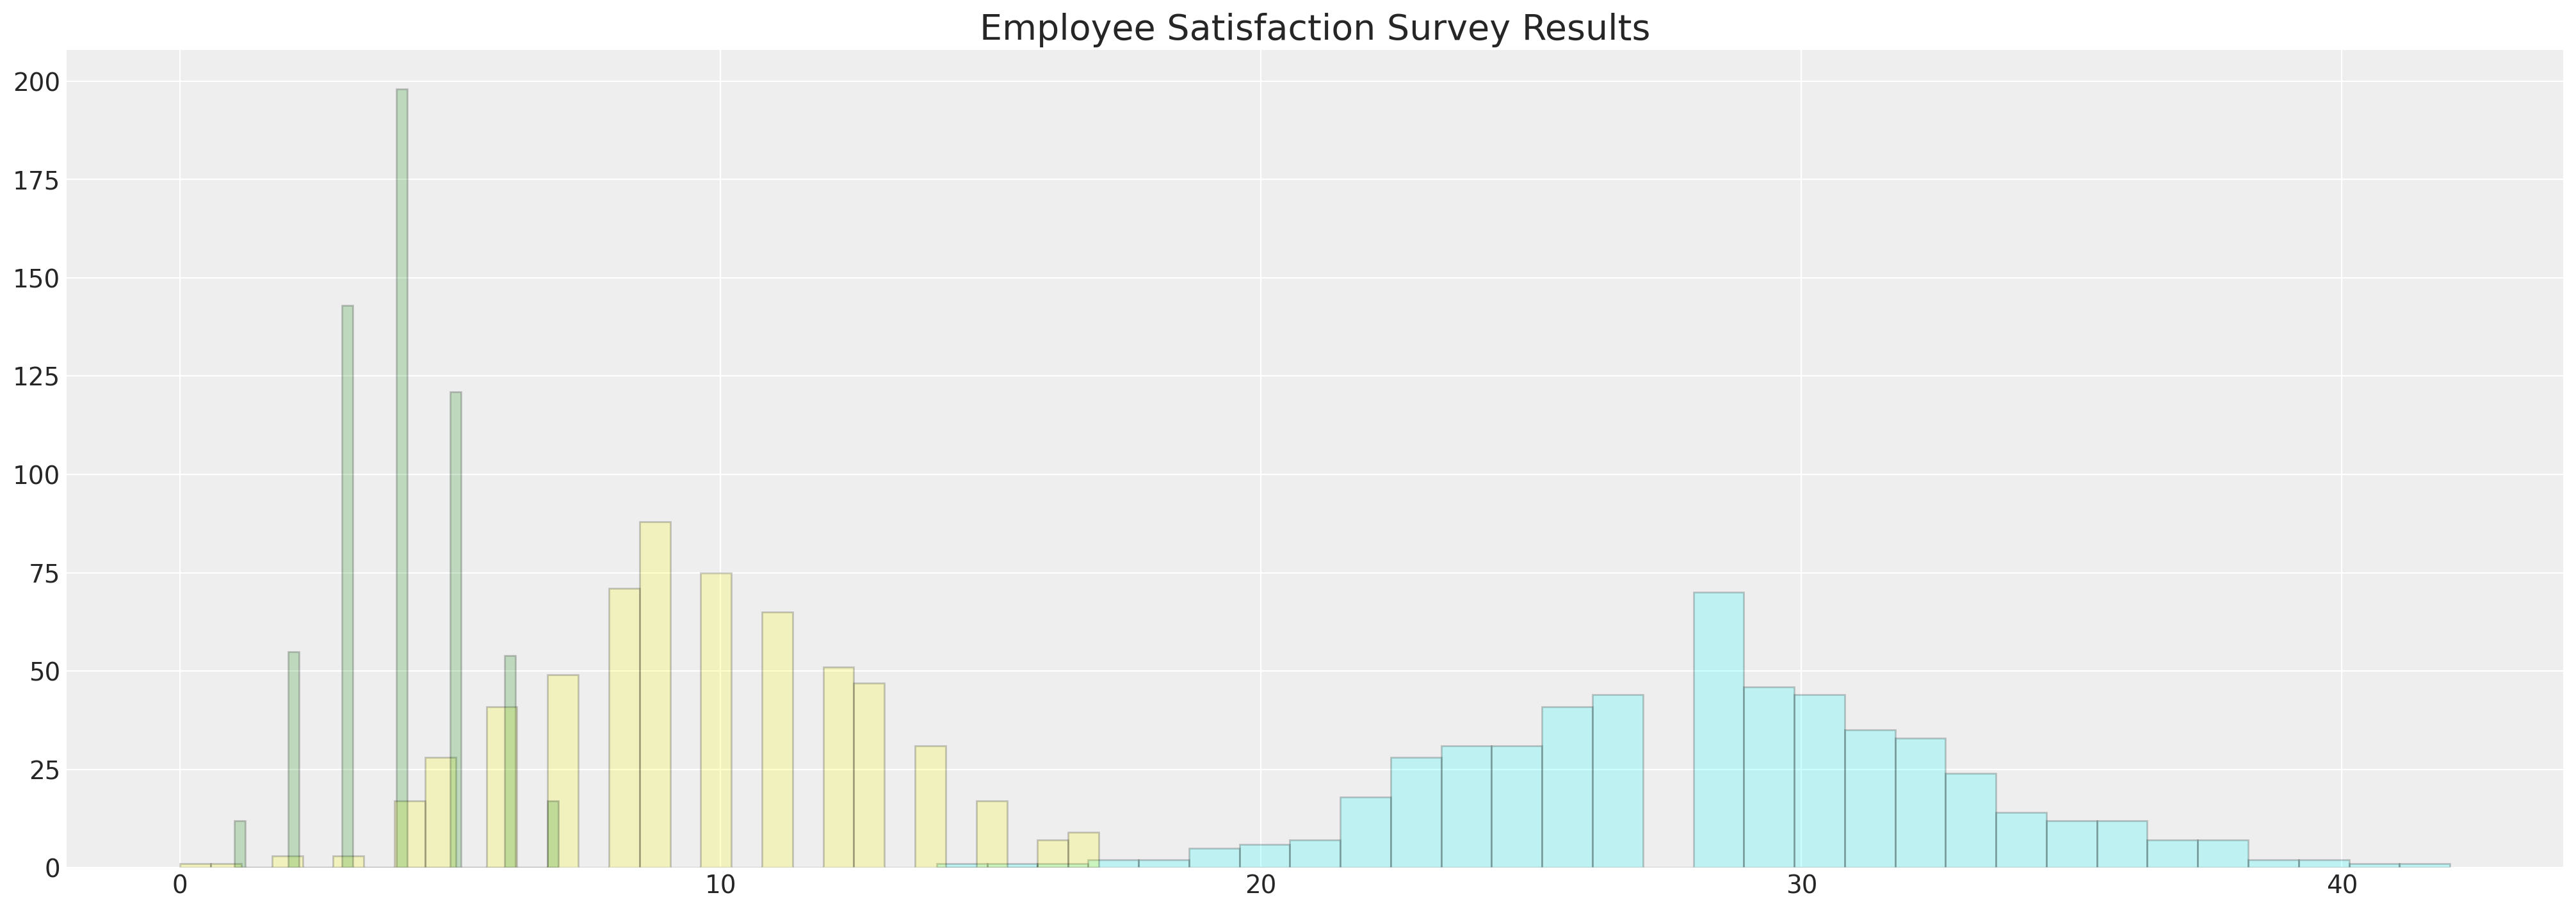

In [431]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(df_employee['empower'], bins=30, ec='black', color='cyan', alpha=0.2, label='Empowerment')
ax.hist(df_employee['lmx'], bins=30, ec='black', color='yellow', alpha=0.2, label='LMX')
ax.hist(df_employee['worksat'], bins=30, ec='black', color='green', alpha=0.2, label='Work Satisfaction')
ax.set_title("Employee Satisfaction Survey Results", fontsize=20)

## The Frequentist Alternative: Full Information Maximum Likelihood



In [537]:

data = df_employee[['worksat', 'empower', 'lmx']]

def split_data_by_missing_pattern(data):
    ## We want to extract our the pattern of missing-ness in our dataset
    ## and save each sub-set of our data in a structure that can be used fed into a log-likelihood function
    grouped_patterns = []
    patterns = data.notnull().drop_duplicates().values
    observed = data.notnull()
    for p in range(len(patterns)):
        temp = observed[(observed['worksat'] == patterns[p][0]) & (observed['empower'] == patterns[p][1]) & (observed['lmx'] == patterns[p][2])]
        grouped_patterns.append([patterns[p], temp.index, data.iloc[temp.index].dropna(axis=1)])

    return grouped_patterns

def flatten_params(mus, cov):
    ### We want to flatten the params so we can feed them into our optimiser
    ## We're assuming that the covariance matrix has a cholesky decomposition
    ## which can be represented by the params of the lower triangular matrix.
    n_vars = len(mus)
    cov_flat = cov[np.tril_indices(n_vars)]
    return np.append(mus, cov_flat)

def reconstitute_params(params_vector, n_vars):
    ## Parse our param vector to feed back into our likelihood function
    mus = params_vector[0:n_vars]
    cov = np.empty((n_vars, n_vars))
    ii, jj = np.tril_indices(n_vars)
    cov[ii, jj] = params_vector[n_vars:]
    cov[jj, ii] = params_vector[n_vars:]
    return mus, cov

def optimise_ll(flat_params, n_vars, grouped_patterns):
    mus, cov = reconstitute_params(flat_params, n_vars)
#
    ## Check if COV is positive definite
    if (np.linalg.eigvalsh(cov) < 0).any():
        return np.inf
    objval = 0.0
    for obs_pattern, _, obs_data in grouped_patterns:
        ## This is the key step because we're selecting the variables which pattern
        ## the full information set within each pattern of "missing-ness"
        ## e.g. when the observed pattern is [True, True, False] with want the first two variables
        ## of the mus vector and we want only the covariance relations between the relevant variables
        obs_mus = mus[obs_pattern]
        obs_cov = cov[obs_pattern][:, obs_pattern]
        ll = np.sum(multivariate_normal(obs_mus, obs_cov).logpdf(obs_data))
        objval = ll + objval
    return -objval

def estimate(data):
    size, n_vars = data.shape
    ## Initialise
    mus0 = np.zeros(n_vars)
    cov0 = np.eye(n_vars)
    params0 = flatten_params(mus0, cov0)
    ## Process Data
    grouped_patterns = split_data_by_missing_pattern(data)
    ## Run the Optimiser. 
    result = sp.optimize.fmin_slsqp(
        optimise_ll, params0, args=(n_vars, grouped_patterns), disp=True)
    mean, cov = reconstitute_params(result, n_vars)
    return mean, cov

def jax_optimise_ll(params, n_vars, grouped_patterns):
    mus = params['mus']
    cov = params['cov']
    cov_t
    print(cov_temp)
    if (jnp.linalg.eigvalsh(cov_temp) < 0).any():
        return jnp.inf
    objval = 0.0
    for obs_pattern, _, obs_data in grouped_patterns:
        ## This is the key step because we're selecting the variables which pattern
        ## the full information set within each pattern of "missing-ness"
        ## e.g. when the observed pattern is [True, True, False] with want the first two variables
        ## of the mus vector and we want only the covariance relations between the relevant variables
        obs_mus = mus[obs_pattern]
        obs_cov = cov_temp[obs_pattern][:, obs_pattern]
        ll = jnp.sum(jax.scipy.stats.multivariate_normal.logpdf(obs_data.values, obs_mus, obs_cov))
        objval = ll + objval
    return -objval


def jax_estimate(data):
    size, n_vars = data.shape
    ## Initialise
    mus0 = jnp.zeros(n_vars)
    cov0 = jnp.eye(n_vars)
    cov_flat = cov0[jnp.tril_indices(n_vars)]
    ## Process Data
    grouped_patterns = split_data_by_missing_pattern(data)
    optimizer = optax.adam(0.005)
    params = {'mus': mus0, "cov": cov_flat}
    opt_state = optimizer.init(params)
    # A simple update loop.
    for _ in range(10):
        grads = jax.grad(jax_optimise_ll)(params, n_vars, grouped_patterns)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates) 
    return params
            
#fiml_mus, fiml_cov = estimate(data)

#print("Full information Maximum Likelihood Estimate Mu:")
#display(pd.DataFrame(fiml_mus, index=data.columns).T)
#print("Full information Maximum Likelihood Estimate COV:") 
#pd.DataFrame(fiml_cov, columns=data.columns,index=data.columns)

jax_estimate(data)
#jax_optimise_ll({'mus': data.mean().values, 'cov': jnp.array(data.cov().values[np.tril_indices(3)])}, 3, grouped_patterns)



IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

In [554]:
mus0 = jnp.zeros(n_vars)*3
cov0 = jnp.eye(n_vars)*2
jnp.dot(jnp.linalg.cholesky(cov0), jnp.linalg.cholesky(cov0).T)






DeviceArray([[1.9999999, 0.       , 0.       ],
             [0.       , 1.9999999, 0.       ],
             [0.       , 0.       , 1.9999999]], dtype=float32)

In [448]:
mle_fit = multivariate_normal(fiml_mus, fiml_cov)
mle_sample = mle_fit.rvs(10000)
mle_sample = pd.DataFrame(mle_sample, columns = ['worksat', 'empower', 'lmx'])
mle_sample


,worksat,empower,lmx
0,2.684775,29.963679,11.924809
1,4.488399,27.496098,3.207609
2,4.765855,31.186431,10.269436
3,4.431789,23.371371,8.468972
4,8.187984,32.272371,13.696901
...,...,...,...
9995,5.105137,36.070066,6.758251
9996,3.828722,25.528785,10.616292
9997,2.425149,27.148588,8.978861
9998,3.167299,34.563367,11.075505


Text(0.5, 1.0, 'Imputed from MLE fit: Employee Satisfaction Survey Results')

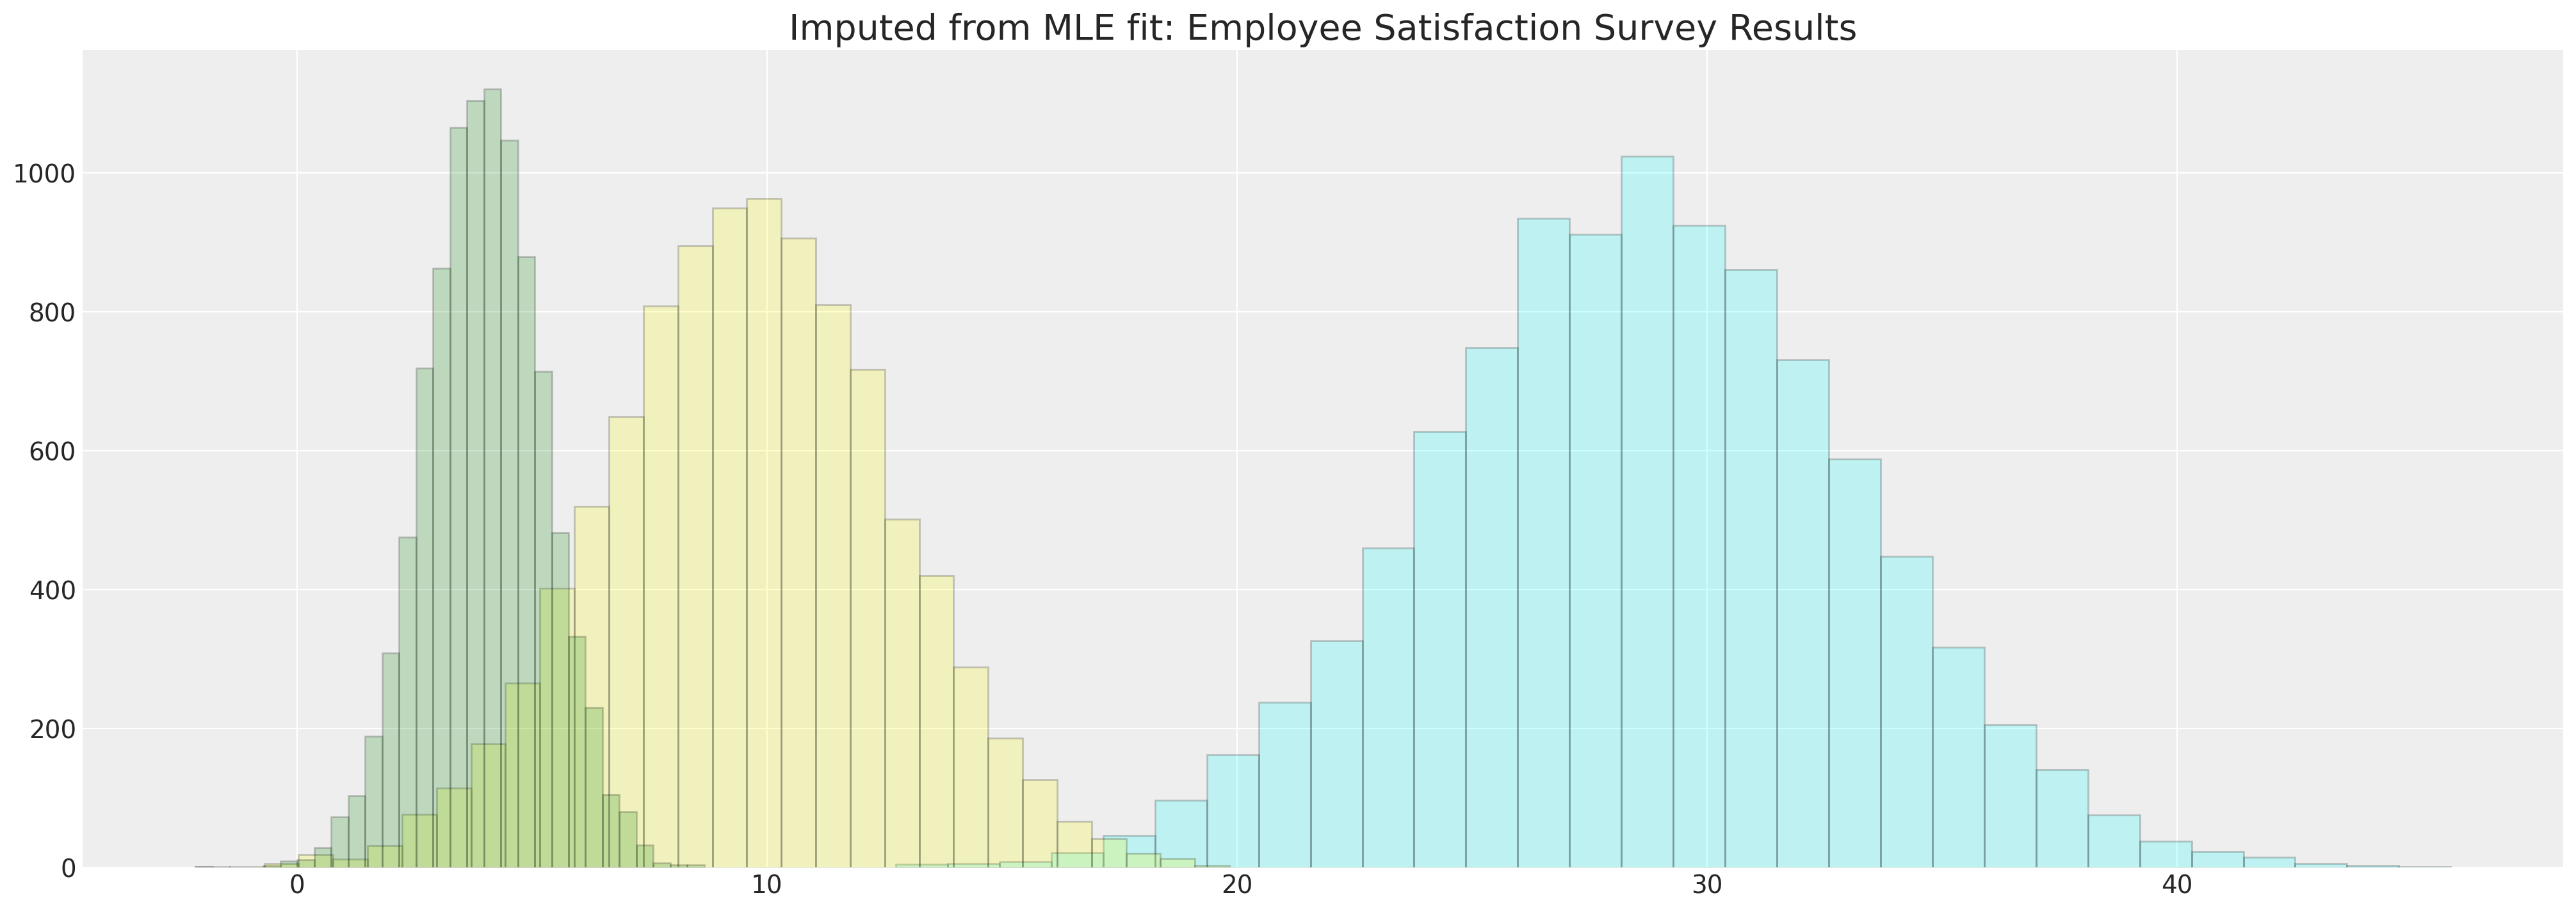

In [436]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(mle_sample['empower'], bins=30, ec='black', color='cyan', alpha=0.2, label='Empowerment')
ax.hist(mle_sample['lmx'], bins=30, ec='black', color='yellow', alpha=0.2, label='LMX')
ax.hist(mle_sample['worksat'], bins=30, ec='black', color='green', alpha=0.2, label='Work Satisfaction')
ax.set_title("Imputed from MLE fit: Employee Satisfaction Survey Results", fontsize=20)

In [444]:
pd.DataFrame(np.corrcoef(fiml_cov), columns=data.columns, index=data.columns)

,worksat,empower,lmx
worksat,1.000000,0.990091,0.114465
empower,0.990091,1.000000,0.252835
lmx,0.114465,0.252835,1.000000


In [230]:
from scipy.optimize import minimize
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal as jax_mvnorm
full_cov = df.cov()
full_mus = df.mean()

fake_complete = pd.DataFrame(np.random.multivariate_normal(full_mus, full_cov, 30))

def ll_mv(params):
    mu = params['mus']
    cov = params['cov']
    ll = jnp.array([jax_mvnorm.logpdf(fake_complete.iloc[i].values, mu, cov) for i in range(len(fake_complete))])
    return jnp.sum(ll)

#ll_mv([full_mus, full_cov.values.flatten()], (fake_complete))
import jax
from jax import jit

init_mus = full_mus.values + np.random.normal(0, 2, (1, 4))
init_covs = full_cov.values #+ np.random.normal(1, 2, (4, 4))
print("INIT MUS: ", init_mus)
print("INIT COV: ", init_covs)
print("-------------------")

optimizer = optax.adam(0.005)
params = {'mus': init_mus, "cov": init_covs}
opt_state = optimizer.init(params)
compute_loss = ll_mv

# A simple update loop.
for _ in range(300):
  grads = jax.grad(compute_loss)(params)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

print("FINAL PARAMS:", params)
print("ACTUAL PARAMS:", full_mus, full_cov)

INIT MUS:  [[15.97795853 37.31291512 21.68753518 46.12578863]]
INIT COV:  [[ 22.83809524  -3.25         9.13636364   8.91208791]
 [ -3.25       116.63235294   9.97142857  47.14285714]
 [  9.13636364   9.97142857  10.72916667  11.39010989]
 [  8.91208791  47.14285714  11.39010989  58.2124183 ]]
-------------------
FINAL PARAMS: {'cov': DeviceArray([[ 24.164448 ,  -5.5717707,   7.0970464,  11.036671 ],
             [ -5.5717707, 114.77596  ,   9.472059 ,  49.28262  ],
             [  7.0970464,   9.472059 ,   8.339994 ,  13.96252  ],
             [ 11.036671 ,  49.28262  ,  13.96252  ,  55.897682 ]],            dtype=float32), 'mus': DeviceArray([[18.35486 , 39.53818 , 23.658424, 44.129276]], dtype=float32)}
ACTUAL PARAMS: read        16.133333
science     34.411765
math        21.062500
medicine    47.722222
dtype: float64                read     science       math   medicine
read      22.838095   -3.250000   9.136364   8.912088
science   -3.250000  116.632353   9.971429  47.142857
math

In [232]:
mu = [2.0, 5.0]
sigma = [[2.5, 0.5], [0.5, 1.5]]
X = multivariate_normal(mu, sigma)


In [249]:
data_X = pd.DataFrame(X.rvs(10000))
data_X.mean()
data_X.cov()


,0,1
0,2.512270,0.506472
1,0.506472,1.517523


In [118]:
import itertools
subjects = ['read', 'math', 'science', 'medicine']
combinations = []
for i in range(1, 4+1):
    combinations.extend(itertools.combinations(subjects, i))
combinations = combinations[4:-1]

{}

[('read', 'math'),
 ('read', 'science'),
 ('read', 'medicine'),
 ('math', 'science'),
 ('math', 'medicine'),
 ('science', 'medicine'),
 ('read', 'math', 'science'),
 ('read', 'math', 'medicine'),
 ('read', 'science', 'medicine'),
 ('math', 'science', 'medicine')]

## Authors
- Authored by [Nathaniel Forde](..) in January 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark


In [3]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Jan 12 2023

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 8.4.0

pytensor: 2.8.11

pandas    : 1.5.1
pymc      : 5.0.1
numpy     : 1.23.4
sys       : 3.9.0 (default, Nov 15 2020, 06:25:35) 
[Clang 10.0.0 ]
matplotlib: 3.6.1
arviz     : 0.14.0

Watermark: 2.3.1

